## Booze R Us Model

Fitting a model (or two) based on our proposal.

- **Goal:** Build a model to predict sales in a month for any given store.
- **Response Variable:** Monthly Sales
- **Possible Features:** store, month, county, population stuff, proximity stuff, alcohol categories

In [1]:
import duckdb as db 
con = db.connect()
import pandas as pd 
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# MAIN TABLE
con.execute("""
        DROP TABLE IF EXISTS sales;
        CREATE TABLE sales AS 
        SELECT EXTRACT(MONTH FROM date) AS month, EXTRACT (YEAR FROM date) AS year,
            store, city, county, 
            category_name AS category, sale_bottles AS bottles, sale_dollars AS dollars
        FROM read_parquet('../data/iowa_liquor_2023_2025.parquet');
""")
sales = con.execute("SELECT * FROM sales").df()

# POPULATION
con.execute(
"""
        DROP TABLE IF EXISTS pop;
        CREATE TABLE population AS
        SELECT name AS county, year_1 AS year, 
                POPESTIMATE AS population, over21, propOver21, median_age_tot AS median_age,
                AGE1824_TOT AS age18to24, AGE2544_TOT AS age25to44
        FROM read_csv_auto('../data/pop.csv');
"""
)
pop = con.execute("SELECT * FROM population").df()

# PROXIMITY
con.execute(
"""
        DROP TABLE IF EXISTS prox;
        CREATE TABLE proximity AS
        SELECT *
        FROM read_csv_auto('../data/proximity.csv');
"""
)
prox = con.execute("SELECT * FROM proximity").df()

In [3]:
sales.columns

Index(['month', 'year', 'store', 'city', 'county', 'category', 'bottles',
       'dollars'],
      dtype='object')

## Creating the Dataset

First, I am going to engineer the category column a little bit to use as features. Knowing which alcohol sells the best is could be useful for telling Booze R Us what they should buy in order to increase profits.

In [4]:
con.execute("""
    CREATE OR REPLACE TABLE sales AS
    SELECT *,
        CASE
            WHEN category ILIKE '%VODKA%' THEN 'Vodka'
            WHEN category ILIKE '%WHISK%' THEN 'Whiskey'
            WHEN category ILIKE '%TEQUILA%' OR category ILIKE '%MEZCAL%' THEN 'Tequila'
            WHEN category ILIKE '%RUM%' THEN 'Rum'
            ELSE 'Other'
        END AS super_category
    FROM sales
""")
sales = con.execute("SELECT * FROM sales").df()

In [5]:
sales.head()

,month,year,store,city,county,category,bottles,dollars,super_category
0,1,2023,4829,DES MOINES,POLK,100% AGAVE TEQUILA,12,261.00,Tequila
1,1,2023,4829,DES MOINES,POLK,AMERICAN VODKAS,60,418.80,Vodka
2,1,2023,4829,DES MOINES,POLK,IMPORTED FLAVORED VODKA,24,358.56,Vodka
3,1,2023,4829,DES MOINES,POLK,CREAM LIQUEURS,12,306.00,Other
4,1,2023,4829,DES MOINES,POLK,SPICED RUM,60,1124.40,Rum


Now I need to agreggate to create our appropriate observational units: monthly sales per store.

- Dollars (our response variable) will be summed. 
- Category will be made into new columns representing the distribution of category sales
    - e.g. 70% tequila, 20% vodkas, etc.
    - we will not use total bottles because this would be almost perfectly collinear 
    - answer questions like: 'what liquor should we sell more/less of?'

In [6]:
monthly_sales = con.execute(
""" 
    WITH month_totals AS (
        SELECT year, month, store, city, county,
            SUM(dollars) AS revenue
        FROM sales
        GROUP BY year, month, store, city, county
    ), category_totals AS (
        SELECT year, month, store, city, county,
            super_category,
            SUM(dollars) AS category_sales
        FROM sales
        GROUP BY year, month, store, city, county, super_category
    )
    SELECT mt.year, mt.month, mt.store, mt.city, mt.county,
        ROUND((SUM(CASE WHEN ct.super_category = 'Vodka' THEN ct.category_sales ELSE 0 END) / mt.revenue),2) AS vodka_ptc,
        ROUND((SUM(CASE WHEN ct.super_category = 'Whiskey' THEN ct.category_sales ELSE 0 END) / mt.revenue),2) AS whiskey_ptc,
        ROUND((SUM(CASE WHEN ct.super_category = 'Tequila' THEN ct.category_sales ELSE 0 END) / mt.revenue),2) AS tequila_ptc,
        ROUND((SUM(CASE WHEN ct.super_category = 'Rum' THEN ct.category_sales ELSE 0 END) / mt.revenue),2) AS rum_ptc,
        ROUND((SUM(CASE WHEN ct.super_category = 'Other' THEN ct.category_sales ELSE 0 END) / mt.revenue),2) AS other_ptc,
        mt.revenue
    FROM month_totals mt
    LEFT JOIN category_totals ct
        ON mt.year = ct.year AND mt.month = ct.month 
            AND mt.city = ct.city AND mt.county = ct.county
            AND mt.store = ct.store 
    WHERE revenue > 0
    GROUP BY mt.year, mt.month, mt.store, mt.city, mt.county, mt.revenue
"""
).fetchdf()

Create a new feature for lagged monthly sales as a predictor. Since there is so much we don't know about individual stores (marketing, promotions, customer behavior, market share, etc...), knowing how they have done in the past can be a good indicator of future performance, making this more of a time series model.

In [7]:
monthly_sales = con.execute(
    """
        -- recreate the duckdb table from the current pandas dataframe
        DROP TABLE IF EXISTS monthly_sales;
        CREATE TABLE monthly_sales AS SELECT * FROM monthly_sales;

        -- add the monthly lagged revenue (leaving out the first month for each store)
        WITH lags AS (
            SELECT *,
                LAG(revenue) OVER (PARTITION BY store ORDER BY year ASC, month ASC) as lag_revenue
            FROM monthly_sales
        )
        SELECT *, LOG(revenue) AS log_revenue, LOG(lag_revenue) AS log_lag_revenue
        FROM lags
        WHERE lag_revenue IS NOT NULL;
    """).fetchdf()

In [8]:
monthly_sales.head(3)

,year,month,store,city,county,vodka_ptc,whiskey_ptc,tequila_ptc,rum_ptc,other_ptc,revenue,lag_revenue,log_revenue,log_lag_revenue
0,2023,2,010040,HOSPERS,SIOUX,0.07,0.38,0.25,0.03,0.26,1040.38,2256.28,3.017192,3.353393
1,2023,3,010040,HOSPERS,SIOUX,0.11,0.54,0.02,0.19,0.14,2270.56,1040.38,3.356133,3.017192
2,2023,4,010040,HOSPERS,SIOUX,0.26,0.31,0.06,0.13,0.24,2047.53,2270.56,3.311230,3.356133


Now I will join with our other datasets, proximity and population. Using an inner join because it still leaves plenty of complete data for modelling. 

In [9]:
df = con.execute(
"""
    -- create table from current monthly_sales df
    DROP TABLE IF EXISTS monthly_sales;
    CREATE TABLE monthly_sales AS SELECT * FROM monthly_sales;

    -- join stuff
    SELECT sales.*, 
        pop.population, pop.over21, pop.propOver21, pop.median_age,
        pop.age18to24 / pop.population AS prop18to24, 
        pop.age25to44 / pop.population AS prop25to44, 
        prox."# of stores within 5 mile radius" AS stores_within_5_miles,
        prox."Nearest other store (mi)" AS nearest_store_miles
    FROM monthly_sales sales
    JOIN pop
        ON LOWER(sales.county) = LOWER(pop.county) AND sales.year = pop.year
    JOIN prox
        ON sales.store = prox.store
"""
).fetchdf()

In [10]:
df.head(2)

,year,month,store,city,county,vodka_ptc,whiskey_ptc,tequila_ptc,rum_ptc,other_ptc,revenue,lag_revenue,log_revenue,log_lag_revenue,population,over21,propOver21,median_age,prop18to24,prop25to44,stores_within_5_miles,nearest_store_miles
0,2023,2,010040,HOSPERS,SIOUX,0.07,0.38,0.25,0.03,0.26,1040.38,2256.28,3.017192,3.353393,36399,26493,0.72785,33.6,0.136432,0.220171,0,7.848419
1,2023,3,010040,HOSPERS,SIOUX,0.11,0.54,0.02,0.19,0.14,2270.56,1040.38,3.356133,3.017192,36399,26493,0.72785,33.6,0.136432,0.220171,0,7.848419


Now encode month to use as a categorical feature:

In [11]:
months = pd.get_dummies(df.month, prefix='month', drop_first=True)
df = pd.concat([df, months], axis=1)
df.head()

,year,month,store,city,county,vodka_ptc,whiskey_ptc,tequila_ptc,rum_ptc,other_ptc,revenue,lag_revenue,log_revenue,log_lag_revenue,population,over21,propOver21,median_age,prop18to24,prop25to44,stores_within_5_miles,nearest_store_miles,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2023,2,010040,HOSPERS,SIOUX,0.07,0.38,0.25,0.03,0.26,1040.38,2256.28,3.017192,3.353393,36399,26493,0.72785,33.6,0.136432,0.220171,0,7.848419,True,False,False,False,False,False,False,False,False,False,False
1,2023,3,010040,HOSPERS,SIOUX,0.11,0.54,0.02,0.19,0.14,2270.56,1040.38,3.356133,3.017192,36399,26493,0.72785,33.6,0.136432,0.220171,0,7.848419,False,True,False,False,False,False,False,False,False,False,False
2,2023,4,010040,HOSPERS,SIOUX,0.26,0.31,0.06,0.13,0.24,2047.53,2270.56,3.311230,3.356133,36399,26493,0.72785,33.6,0.136432,0.220171,0,7.848419,False,False,True,False,False,False,False,False,False,False,False
3,2023,5,010040,HOSPERS,SIOUX,0.14,0.62,0.00,0.15,0.09,2102.17,2047.53,3.322668,3.311230,36399,26493,0.72785,33.6,0.136432,0.220171,0,7.848419,False,False,False,True,False,False,False,False,False,False,False
4,2023,6,010040,HOSPERS,SIOUX,0.20,0.31,0.00,0.32,0.16,2253.30,2102.17,3.352819,3.322668,36399,26493,0.72785,33.6,0.136432,0.220171,0,7.848419,False,False,False,False,True,False,False,False,False,False,False


In [12]:
df = df.copy()
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df = df[df['revenue'] > 0]   
df.to_csv('../data/brs_model_data.csv', index=False)

## Linear Regression (from scratch)

First, the function to fit the model. It will take observed X and Y matrices and return the predictions and estimators.

In [13]:
def fit_lr(X, Y):
    
    X = np.column_stack([np.ones((X.shape[0], 1)), X.astype(float)]) # add column of ones
    B = np.linalg.pinv(X.T @ X) @ X.T @ Y

    return B

In [14]:
def predict_lr(X, B):
    
    X = np.column_stack([np.ones((X.shape[0], 1)), X.astype(float)]) # add column of ones
    Y_hat = X @ B

    return Y_hat

A cross validation function:

In [15]:
def lr_cross_val(data, features, response, k=5):

    # save original indices before sorting so we can map to the correct y values later
    df = data.copy()
    df['og_idx'] = df.index

    # sort for time-based sequential folds
    data_sorted = df.sort_values(['year','month']).reset_index(drop=True)

    # create month blocks based on number of folds
    periods = (data_sorted["year"].astype(str) + '-' + data_sorted["month"].astype(str).str.zfill(2)).to_numpy()
    unique_periods = np.unique(periods)
    k = max(2, min(k, len(unique_periods)))
    month_blocks = np.array_split(unique_periods, k)

    # make predictions for each fold aligned with the sorted dataframe
    preds_sorted = pd.Series(np.nan, index=data_sorted.index, dtype=float)
    fold_rows = []
    for fold in range(1, len(month_blocks)):
        
        # training data = all folds before this fold
        # testing data = this fold only
        train_months = np.concatenate(month_blocks[:fold])
        test_months  = month_blocks[fold]
        train_mask = np.isin(periods, train_months)
        test_mask  = np.isin(periods, test_months)
        train = data_sorted.loc[train_mask]
        test  = data_sorted.loc[test_mask]

        # fit with training data and predict testing data
        B = fit_lr(train[features].values, train[response].values)
        yhat = predict_lr(test[features].values, B)
        preds_sorted.loc[test.index] = yhat

        # compute per-fold metrics
        y_true = test[response].to_numpy()
        rss = np.sum((y_true - yhat)**2)
        tss = np.sum((y_true - y_true.mean())**2)
        r2  = 1 - rss/tss if tss > 0 else np.nan
        mae = np.mean(np.abs(y_true - yhat))
        rmse = np.sqrt(np.mean((y_true - yhat)**2))
        fold_rows.append({
            "fold": fold,
            "train_months": f"{train_months[0]} to {train_months[-1]}",
            "test_months":  f"{test_months[0]} to {test_months[-1]}",
            "n_train": len(train),
            "n_test": len(test),
            "R2": r2, "MAE": mae, "RMSE": rmse
        })

    # map all predictions back using the saved original index to make full df evaluations
    preds = pd.Series(index=df['og_idx'], dtype=float)
    preds.loc[data_sorted['og_idx'].values] = preds_sorted.values
    preds = preds.reindex(data.index) 

    # calculate metrics based on the full dataset
    ## excluding the first fold because those dont get predictions
    metrics_df = pd.DataFrame(fold_rows)
    valid = preds.notna()
    y_all = data.loc[valid, response].to_numpy()
    yhat_all = preds.loc[valid].to_numpy()
    rss = np.sum((y_all - yhat_all)**2)
    tss = np.sum((y_all - y_all.mean())**2)
    overall = {
        "overall_R2": 1 - rss/tss if tss > 0 else np.nan,
        "overall_MAE": float(np.mean(np.abs(y_all - yhat_all))),
        "overall_RMSE": float(np.sqrt(np.mean((y_all - yhat_all)**2))),
        "n_eval": int(valid.sum())
    }

    return preds, metrics_df, overall


Fit the model:

- *NOTE:* I first fit with all possible features, then after assessing model fit, feature importance, and multicollinearity (all below), I came back up and changed the features. So this is just the final model here, not all iterations.

In [16]:
features = ['month_5','month_6', 'month_10', 'month_11', 'month_12',
        'vodka_ptc', 'whiskey_ptc', 'rum_ptc', 'tequila_ptc',
        'prop25to44',
        'log_lag_revenue']
response = 'log_revenue'

# fit
yhat, fold_metrics, overall = lr_cross_val(df, features, response, k=5)

 Assess model fit:

In [17]:
fold_metrics

,fold,train_months,test_months,n_train,n_test,R2,MAE,RMSE
0,1,2023-02 to 2023-06,2023-07 to 2023-11,8289,8547,0.785449,0.170153,0.231092
1,2,2023-02 to 2023-11,2023-12 to 2024-04,16836,8639,0.790733,0.164061,0.223993
2,3,2023-02 to 2024-04,2024-05 to 2024-08,25475,6991,0.786873,0.165910,0.224983
3,4,2023-02 to 2024-08,2024-09 to 2024-12,32466,7067,0.797228,0.163453,0.221798


In [18]:
overall

{'overall_R2': 0.790008912409923,
 'overall_MAE': 0.1660036928887814,
 'overall_RMSE': 0.22568725054994407,
 'n_eval': 31244}

Fit a model on all the data and look at the estimators:

In [19]:
# fit a final model on all the data
X = df[features]
Y = df[response]
B_final = fit_lr(X, Y)

In [20]:
coef_names = ['intercept'] + list(X.columns)
nonstd_df = pd.DataFrame({
    'feature': coef_names,
    'beta': B_final
})
nonstd_df = nonstd_df[nonstd_df['feature'] != 'intercept']
nonstd_df = nonstd_df.reindex(
    nonstd_df['beta'].abs().sort_values(ascending=False).index
)
print(nonstd_df)

            feature      beta
11  log_lag_revenue  0.867871
10       prop25to44  0.415014
8           rum_ptc  0.181792
6         vodka_ptc -0.142137
7       whiskey_ptc -0.120453
9       tequila_ptc  0.109473
1           month_5  0.054933
3          month_10  0.037207
4          month_11  0.017080
2           month_6  0.011468
5          month_12  0.009121


Check standardized coefficients because their magnitudes actually tell us importance:

In [21]:

X_std = X.apply(pd.to_numeric, errors='coerce').astype(float).std(axis=0, ddof=0).to_numpy()
Y_std = pd.to_numeric(Y, errors='coerce').astype(float).std(ddof=0)
beta_no_intercept = np.ravel(B_final[1:])  # shape (p,)
std_beta = beta_no_intercept * (X_std / Y_std)
importance = (pd.DataFrame({"feature": X.columns, "std_coef": std_beta})
                .sort_values("std_coef", key=np.abs, ascending=False)
                .reset_index(drop=True))

print(importance)


            feature  std_coef
0   log_lag_revenue  0.864717
1       whiskey_ptc -0.033255
2           month_5  0.031324
3         vodka_ptc -0.028852
4           rum_ptc  0.023675
5        prop25to44  0.023485
6          month_10  0.021305
7       tequila_ptc  0.017640
8          month_11  0.009813
9           month_6  0.006575
10         month_12  0.005260


Check for collinearity between features:

In [22]:
# compute correlation matrix for numeric features
corr = X.corr().abs()

# show only the top correlated pairs
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
)
print("Most correlated feature pairs:\n")
print(high_corr.head(10))


Most correlated feature pairs:

whiskey_ptc  tequila_ptc        0.471527
             log_lag_revenue    0.308219
vodka_ptc    whiskey_ptc        0.299025
tequila_ptc  log_lag_revenue    0.253883
             prop25to44         0.212498
rum_ptc      prop25to44         0.197471
             tequila_ptc        0.177275
prop25to44   log_lag_revenue    0.175556
whiskey_ptc  prop25to44         0.174682
vodka_ptc    tequila_ptc        0.169100
dtype: float64


I've removed the heavily collinear variables and re-ran. Most notably, I decided to remove stores_within_5_miles because of its collinearity with prop25to44. Removing it revealed a very strong correlation between this proportion and revenue. And by itself, the store proximity didn't seem to matter as much.

In [23]:
df.loc[yhat.notna(), response]

5        3.305803
6        3.354254
7        3.033138
8        3.358806
9        3.361318
           ...   
39528    4.282191
39529    4.530718
39530    4.627801
39531    4.185313
39532    4.563684
Name: log_revenue, Length: 31244, dtype: float64

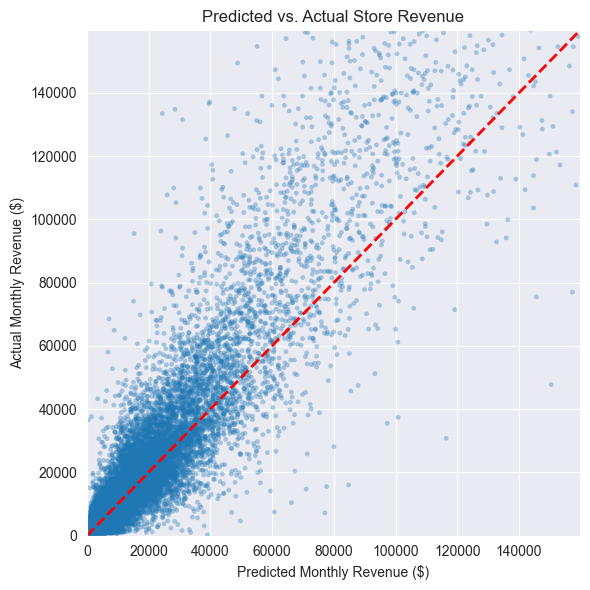

In [31]:
# 1) align CV preds to the df rows
df['predicted_log_revenue'] = yhat.reindex(df.index)

# 2) keep only rows with OOF predictions
mask = df['predicted_log_revenue'].notna()

# 3) back-transform predictions to dollars (BASE-10)
predicted_revenue = np.power(10.0, df.loc[mask, 'predicted_log_revenue'].to_numpy())
actual_revenue    = df.loc[mask, 'revenue'].to_numpy()  # already in dollars

# (optional) bias correction for log10 back-transform
resid = df.loc[mask, 'log_revenue'].to_numpy() - df.loc[mask, 'predicted_log_revenue'].to_numpy()
sigma2 = resid.var()  # variance on log10 scale
predicted_revenue_bc = predicted_revenue * np.exp((np.log(10.0)**2) * sigma2 / 2.0)

plt.figure(figsize=(6,6))
plt.scatter(predicted_revenue, actual_revenue, alpha=0.35, s=12, edgecolor='none')
plt.plot([0, actual_revenue.max()/3], [0, actual_revenue.max()/3], 'r--', lw=2)
plt.xlim(0, actual_revenue.max()/10)
plt.ylim(0, actual_revenue.max()/10)
plt.xlabel('Predicted Monthly Revenue ($)')
plt.ylabel('Actual Monthly Revenue ($)')
plt.title('Predicted vs. Actual Store Revenue')
plt.tight_layout()
plt.show()


In [25]:
actual_revenue.max(), predicted_revenue.max(), df.revenue.max()

(1597586.210000002, 972307.9555736028, 1597586.210000002)

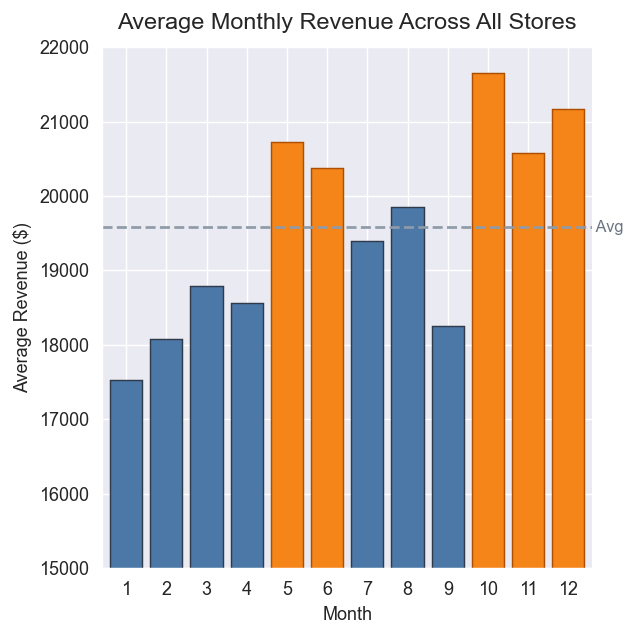

In [26]:
monthly_avg = df.groupby('month', as_index=False)['revenue'].mean()
x = monthly_avg['month'].to_numpy()
y = monthly_avg['revenue'].to_numpy()

peaks = {5, 6, 10, 11, 12}
colors = ['#4C78A8' if m not in peaks else '#F58518' for m in x]  # base blue, highlight orange
edge = ['#2F3B4A' if m not in peaks else '#AD4E00' for m in x]

fig, ax = plt.subplots(figsize=(5,5), dpi=130)
bars = ax.bar(x, y, color=colors, edgecolor=edge, linewidth=0.8)

avg = y.mean()
ax.axhline(avg, ls='--', lw=1.5, color='#8F9BA8')
ax.text(12.6, avg, ' Avg', va='center', ha='left', color='#6B7683', fontsize=9)

ax.set_title('Average Monthly Revenue Across All Stores', fontsize=13, pad=10)
ax.set_xlabel('Month')
ax.set_ylabel('Average Revenue ($)')
ax.set_xticks(np.arange(1,13))
ax.set_xlim(0.4, 12.6)
ax.set_ylim(15000, 22000)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


/var/folders/7p/z1yhq0cd15gfxr0801ffj1200000gn/T/ipykernel_64764/597964046.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corrs.values, y=corrs.index, palette=['#D62728' if v < 0 else '#2CA02C' for v in corrs.values], alpha=0.7)


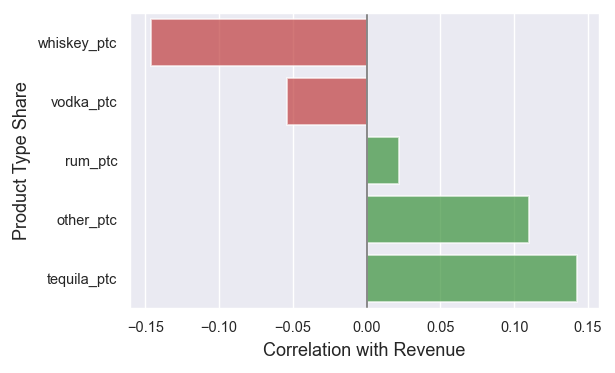

In [27]:


mix_cols = ['vodka_ptc', 'whiskey_ptc', 'tequila_ptc', 'rum_ptc', 'other_ptc']

corrs = df[mix_cols + ['revenue']].corr()['revenue'].drop('revenue').sort_values()

plt.figure(figsize=(5,3), dpi=130)
# change the colors to red and green based on positive or negative correlation
sns.barplot(x=corrs.values, y=corrs.index, palette=['#D62728' if v < 0 else '#2CA02C' for v in corrs.values], alpha=0.7)
plt.xlabel('Correlation with Revenue')
plt.ylabel('Product Type Share')
plt.axvline(0, color='gray', lw=1)
plt.tight_layout()
# decrease font on axis
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()
